In [23]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2019-01-01'
end = '2022-08-30'

In [24]:
# Tickers of commodities
assets = ['GC=F','MGC=F','SI=F','SIL=F','PL=F','HG=F','PA=F','CL=F','HO=F','NG=F','RB=F','BZ=F','ZC=F','ZO=F','KE=F','ZR=F','ZM=F','ZL=F','ZS=F','GF=F','HE=F','LE=F','CC=F','KC=F','CT=F','LBS=F','OJ=F','SB=F'
]
assets.sort()

In [25]:
# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets
# Calculating returns
Y = data[assets].pct_change().dropna()
display(Y.head())

[*********************100%***********************]  28 of 28 completed


,BZ=F,CC=F,CL=F,CT=F,GC=F,GF=F,HE=F,HG=F,HO=F,KC=F,...,RB=F,SB=F,SI=F,SIL=F,ZC=F,ZL=F,ZM=F,ZO=F,ZR=F,ZS=F
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-08,1.2693%,-0.9444%,1.3899%,-0.2201%,-0.2896%,-0.1440%,-0.8229%,-1.0637%,0.6976%,-1.9582%,...,0.0986%,0.0513%,-1.3233%,-1.3233%,0.5043%,-0.5367%,0.0296%,-0.1009%,0.0000%,0.1576%
2021-09-09,-1.5840%,-0.5134%,-1.6739%,-0.6723%,0.3742%,-0.1922%,-2.1745%,1.2169%,-1.0625%,-1.4647%,...,-1.5196%,-1.2827%,0.5039%,0.5039%,-0.4516%,-2.4891%,-0.3260%,-2.2727%,-0.1145%,-0.9443%
2021-09-10,2.0574%,-2.5802%,2.3188%,0.7086%,-0.4340%,-0.9631%,-3.5390%,3.8403%,1.5281%,0.3243%,...,2.5861%,-2.3389%,-1.1519%,-1.1519%,1.3609%,-0.4998%,1.6949%,0.7752%,1.3374%,1.3108%
2021-09-13,0.8091%,1.2864%,1.0470%,-0.8611%,0.1341%,-1.3290%,-2.0315%,-1.8997%,0.5732%,-0.6735%,...,0.3203%,1.0112%,-0.4276%,-0.4276%,-1.1934%,0.1076%,0.7895%,0.9744%,0.4902%,-0.2156%
2021-09-14,0.1224%,0.7097%,0.0142%,0.5826%,0.7087%,2.0204%,-0.4952%,-1.0427%,0.1390%,-0.7323%,...,0.5322%,-0.1054%,0.3747%,0.3747%,1.2582%,1.5771%,-1.0154%,2.7933%,0.8255%,0.3143%


Otimização do portfólio de paridade de risco hierárquico (HRP)

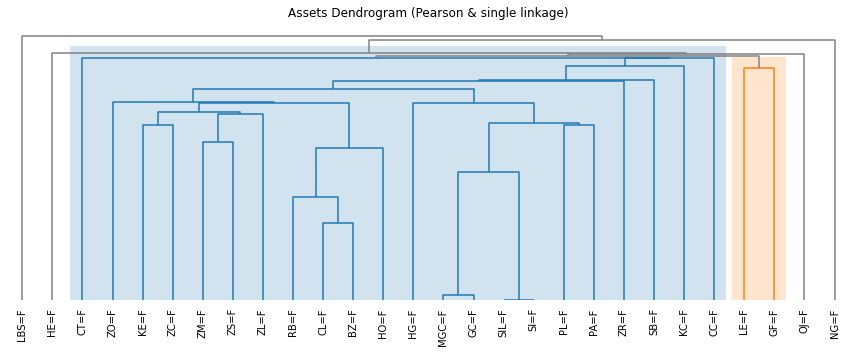

In [26]:
import riskfolio as rp

# Plotting Assets Clusters

ax = rp.plot_dendrogram(returns=Y,
                        codependence='pearson',
                        linkage='single',
                        k=None,
                        max_k=10,
                        leaf_order=True,
                        ax=None)

O dendrograma acima sugere que o número ideal de aglomerados são quatro. No entanto, as carteiras HRP não usam uma série de clusters como entrada.

Estimando o portfólio hrp
Este é o modelo original proposto por López de Prado (2016). Riskfolio-Lib expande esse modelo para 14 medidas de risco.

Cálculo da carteira HRP

In [27]:
# Building the portfolio object
port = rp.HCPortfolio(returns=Y)

# Estimate optimal portfolio:

model='HRP' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'single' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

display(w.T)

,BZ=F,CC=F,CL=F,CT=F,GC=F,GF=F,HE=F,HG=F,HO=F,KC=F,...,RB=F,SB=F,SI=F,SIL=F,ZC=F,ZL=F,ZM=F,ZO=F,ZR=F,ZS=F
weights,0.4515%,4.5694%,0.4238%,2.5745%,5.1226%,14.7626%,2.5738%,2.0138%,0.4823%,2.5422%,...,0.6060%,7.5888%,2.0987%,1.3876%,2.0067%,0.9931%,1.3089%,0.8036%,6.8637%,2.3941%


Composição do portfólio -  plotagem

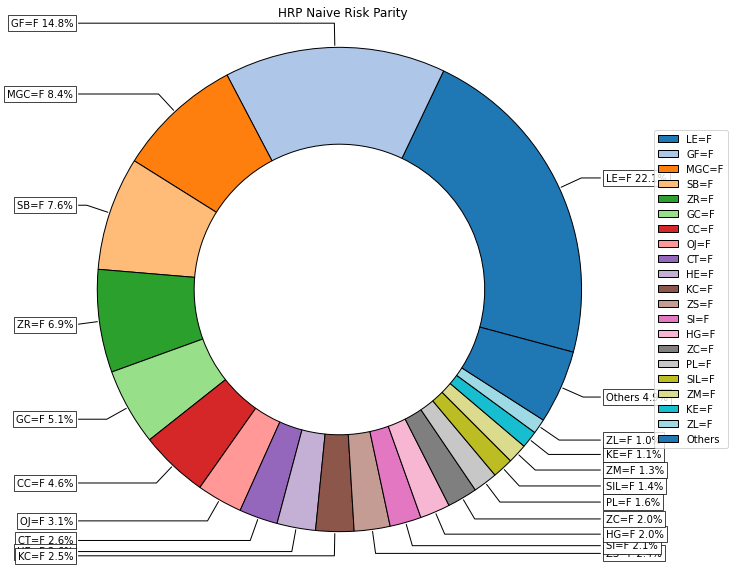

In [28]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w,
                 title='HRP Naive Risk Parity',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

Plotagem contribuição de risco

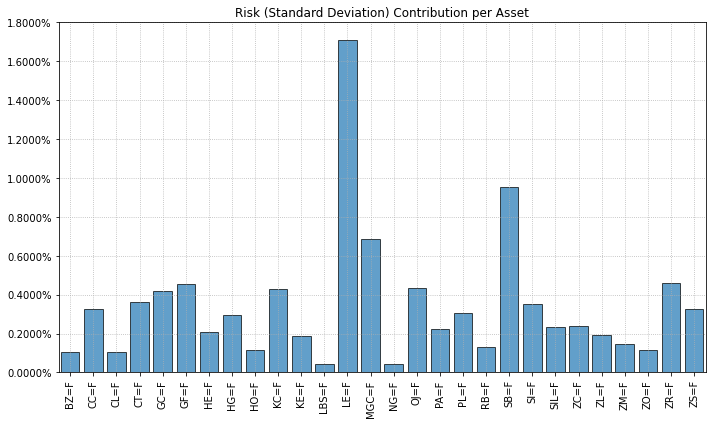

In [29]:
# Plotting the risk contribution per asset

mu = Y.mean()
cov = Y.cov() # Covariance matrix
returns = Y # Returns of the assets

ax = rp.plot_risk_con(w=w,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

Calcula carteiras hrp ideais para várias medidas de risco

In [31]:
# Risk Measures available:
#
# 'vol': Standard Deviation.
# 'MV': Variance.
# 'MAD': Mean Absolute Deviation.
# 'GMD': Gini Mean Difference.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'VaR': Conditional Value at Risk.
# 'CVaR': Conditional Value at Risk.
# 'TG': Tail Gini.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax).
# 'RG': Range of returns.
# 'CVRG': CVaR Range of returns.
# 'TGRG': Tail Gini Range of returns.
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'DaR': Drawdown at Risk of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.
# 'MDD_Rel': Maximum Drawdown of compounded cumulative returns (Calmar Ratio).
# 'ADD_Rel': Average Drawdown of compounded cumulative returns.
# 'DaR_Rel': Drawdown at Risk of compounded cumulative returns.
# 'CDaR_Rel': Conditional Drawdown at Risk of compounded cumulative returns.
# 'EDaR_Rel': Entropic Drawdown at Risk of compounded cumulative returns.
# 'UCI_Rel': Ulcer Index of compounded cumulative returns.

rms = ['vol', 'MV', 'MAD', 'GMD', 'MSV', 'FLPM', 'SLPM', 'VaR',
       'CVaR', 'TG', 'EVaR', 'WR', 'RG', 'CVRG', 'TGRG', 'MDD', 
       'ADD', 'DaR', 'CDaR', 'EDaR', 'UCI', 'MDD_Rel',
       'ADD_Rel', 'DaR_Rel', 'CDaR_Rel', 'EDaR_Rel', 'UCI_Rel']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model,
                          codependence=codependence,
                          rm=i,
                          rf=rf,
                          linkage=linkage,
                          max_k=max_k,
                          leaf_order=leaf_order)

    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [32]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,vol,MV,MAD,GMD,MSV,FLPM,SLPM,VaR,CVaR,TG,EVaR,WR,RG,CVRG,TGRG,MDD,ADD,DaR,CDaR,EDaR,UCI,MDD_Rel,ADD_Rel,DaR_Rel,CDaR_Rel,EDaR_Rel,UCI_Rel
BZ=F,1.35%,0.45%,1.48%,1.42%,1.30%,1.50%,1.31%,1.22%,1.17%,1.15%,1.07%,1.02%,1.11%,1.23%,1.18%,2.06%,1.40%,1.70%,1.80%,1.89%,1.48%,1.95%,1.27%,1.69%,1.73%,1.81%,1.40%
CC=F,4.28%,4.57%,4.17%,4.24%,4.19%,3.78%,3.97%,4.16%,4.09%,3.99%,4.03%,4.17%,4.56%,4.25%,4.25%,3.79%,3.06%,4.01%,4.14%,3.99%,3.60%,3.86%,3.04%,4.02%,4.18%,4.05%,3.60%
CL=F,1.31%,0.42%,1.38%,1.34%,1.26%,1.38%,1.26%,1.16%,1.14%,1.14%,1.08%,1.06%,1.32%,1.21%,1.20%,1.74%,1.23%,1.47%,1.52%,1.60%,1.28%,1.81%,1.19%,1.55%,1.60%,1.68%,1.30%
CT=F,3.71%,2.57%,3.67%,3.61%,3.41%,3.89%,3.48%,3.90%,3.33%,3.23%,2.96%,2.86%,2.89%,3.73%,3.83%,2.68%,3.22%,2.38%,2.48%,2.54%,2.79%,2.63%,3.28%,2.44%,2.45%,2.50%,2.82%
GC=F,4.27%,5.12%,4.16%,4.23%,4.25%,3.79%,4.03%,3.52%,3.92%,4.16%,4.34%,4.34%,5.04%,4.06%,4.23%,2.15%,1.80%,1.79%,1.91%,2.02%,1.85%,2.24%,1.82%,1.82%,1.98%,2.10%,1.88%
GF=F,8.21%,14.76%,8.12%,8.18%,9.46%,8.88%,10.13%,9.24%,11.06%,11.70%,13.46%,15.28%,9.02%,8.44%,8.57%,11.37%,14.17%,14.24%,13.17%,12.45%,14.01%,11.07%,14.20%,13.61%,12.72%,12.05%,13.93%
HE=F,3.71%,2.57%,4.27%,4.00%,4.05%,4.32%,4.09%,4.86%,3.52%,3.36%,3.98%,3.93%,2.46%,3.19%,2.94%,4.71%,3.76%,4.19%,4.21%,4.35%,3.95%,4.23%,3.66%,4.10%,3.94%,4.00%,3.81%
HG=F,2.79%,2.01%,2.69%,2.70%,2.88%,2.45%,2.73%,2.63%,2.83%,2.81%,3.01%,3.19%,3.20%,2.82%,2.81%,1.84%,1.28%,1.27%,1.42%,1.56%,1.34%,2.01%,1.40%,1.51%,1.62%,1.75%,1.53%
HO=F,1.36%,0.48%,1.59%,1.50%,1.32%,1.70%,1.34%,1.81%,1.20%,1.06%,0.87%,0.78%,0.96%,1.20%,1.10%,1.71%,1.15%,1.28%,1.39%,1.49%,1.18%,1.84%,1.20%,1.43%,1.55%,1.64%,1.28%
KC=F,3.19%,2.54%,3.10%,3.16%,3.25%,3.10%,3.27%,3.46%,3.36%,3.30%,3.38%,3.45%,3.46%,3.20%,3.25%,3.67%,3.47%,3.99%,4.01%,3.83%,3.77%,3.56%,3.31%,3.90%,3.90%,3.76%,3.63%


<AxesSubplot:>

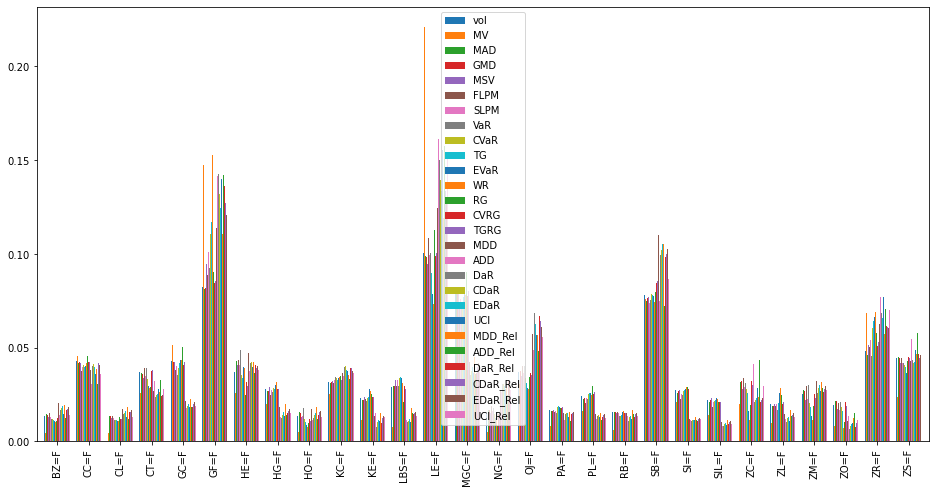

In [33]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(16)
fig.set_figheight(8)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot(kind='bar', width=0.8, ax=ax)

Otimização hierárquica do portfólio de Contribuição de Igualdade de Risco (HERC)¶

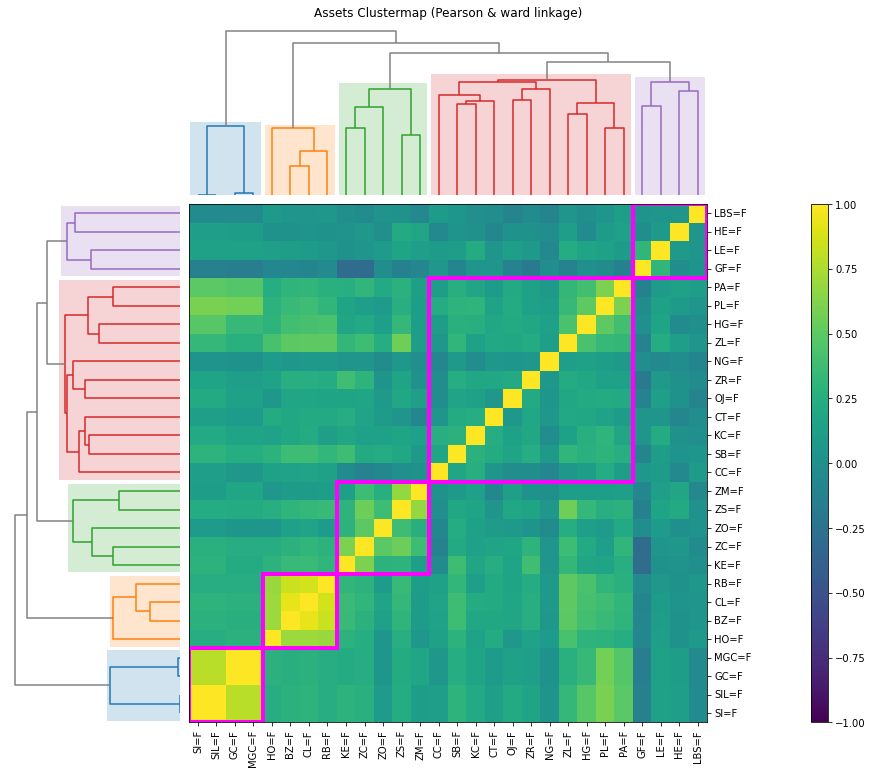

In [34]:
import riskfolio as rp

# Plotting Assets Clusters

ax = rp.plot_clusters(returns=Y,
                      codependence='pearson',
                      linkage='ward',
                      k=None,
                      max_k=10,
                      leaf_order=True,
                      dendrogram=True,
                      #linecolor='tab:purple',
                      ax=None)

O gráfico acima sugere que o número ideal de clusters são Cinco.

Estimando o portfólio herc

Este é o modelo original proposto por Raffinot (2018). Riskfolio-Lib expande esse modelo para 14 medidas de risco.

Cálculo da carteira HERC

In [35]:
# Building the portfolio object
port = rp.HCPortfolio(returns=Y)

# Estimate optimal portfolio:

model='HERC' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'ward' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

display(w.T)

,BZ=F,CC=F,CL=F,CT=F,GC=F,GF=F,HE=F,HG=F,HO=F,KC=F,...,RB=F,SB=F,SI=F,SIL=F,ZC=F,ZL=F,ZM=F,ZO=F,ZR=F,ZS=F
weights,0.7901%,0.1540%,0.7418%,0.0631%,36.1608%,0.8343%,0.1300%,0.1459%,0.5395%,0.0857%,...,0.7697%,0.2063%,9.7951%,9.7951%,0.5013%,0.0817%,0.3270%,0.1887%,0.3146%,0.5926%


Composição do portfólio plotagem

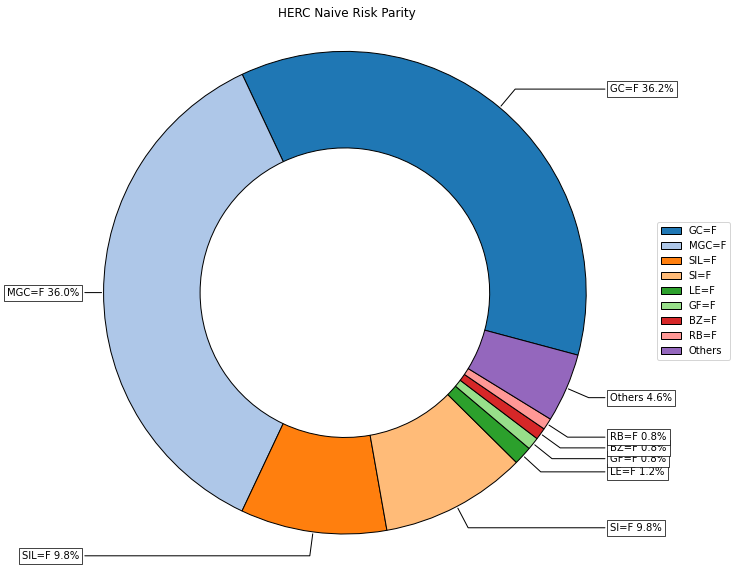

In [38]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w,
                 title='HERC Naive Risk Parity',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

Plotagem contribuição de risco

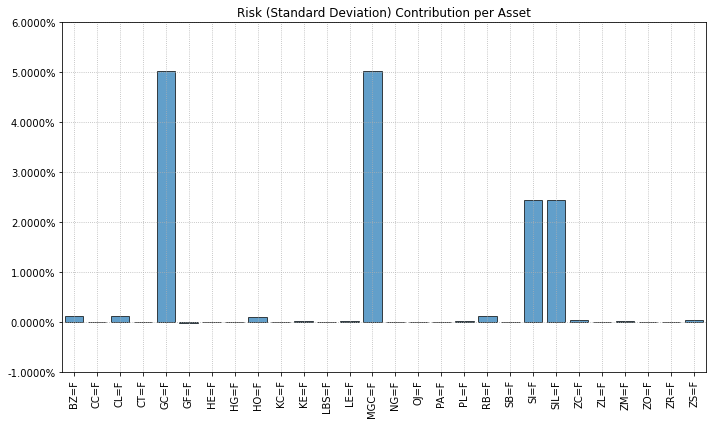

In [39]:
# Plotting the risk contribution per asset

mu = Y.mean()
cov = Y.cov() # Covariance matrix
returns = Y # Returns of the assets

ax = rp.plot_risk_con(w=w,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

Calcular carteiras HERC ideais para várias medidas de risco

In [41]:
#Risk Measures available:
#
# 'vol': Standard Deviation.
# 'MV': Variance.
# 'MAD': Mean Absolute Deviation.
# 'GMD': Gini Mean Difference.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'VaR': Conditional Value at Risk.
# 'CVaR': Conditional Value at Risk.
# 'TG': Tail Gini.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax).
# 'RG': Range of returns.
# 'CVRG': CVaR Range of returns.
# 'TGRG': Tail Gini Range of returns.
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'DaR': Drawdown at Risk of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.
# 'MDD_Rel': Maximum Drawdown of compounded cumulative returns (Calmar Ratio).
# 'ADD_Rel': Average Drawdown of compounded cumulative returns.
# 'DaR_Rel': Drawdown at Risk of compounded cumulative returns.
# 'CDaR_Rel': Conditional Drawdown at Risk of compounded cumulative returns.
# 'EDaR_Rel': Entropic Drawdown at Risk of compounded cumulative returns.
# 'UCI_Rel': Ulcer Index of compounded cumulative returns.

rms = ['vol', 'MV', 'MAD', 'GMD', 'MSV', 'FLPM', 'SLPM', 'VaR',
       'CVaR', 'TG', 'EVaR', 'WR', 'RG', 'CVRG', 'TGRG', 'MDD', 
       'ADD', 'DaR', 'CDaR', 'EDaR', 'UCI', 'MDD_Rel',
       'ADD_Rel', 'DaR_Rel', 'CDaR_Rel', 'EDaR_Rel', 'UCI_Rel']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model,
                          codependence=codependence,
                          rm=i,
                          rf=rf,
                          linkage=linkage,
                          max_k=max_k,
                          leaf_order=leaf_order)

    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [42]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,vol,MV,MAD,GMD,MSV,FLPM,SLPM,VaR,CVaR,TG,EVaR,WR,RG,CVRG,TGRG,MDD,ADD,DaR,CDaR,EDaR,UCI,MDD_Rel,ADD_Rel,DaR_Rel,CDaR_Rel,EDaR_Rel,UCI_Rel
BZ=F,2.24%,0.79%,2.47%,2.36%,2.13%,2.75%,2.25%,2.29%,1.98%,1.82%,1.67%,1.47%,1.58%,2.11%,1.97%,4.70%,4.83%,4.98%,4.90%,4.81%,4.77%,4.25%,4.23%,4.60%,4.44%,4.36%,4.24%
CC=F,0.16%,0.15%,0.15%,0.15%,0.16%,0.15%,0.16%,0.14%,0.16%,0.17%,0.16%,0.16%,0.16%,0.16%,0.16%,0.18%,0.23%,0.26%,0.23%,0.21%,0.24%,0.17%,0.22%,0.24%,0.21%,0.20%,0.23%
CL=F,2.17%,0.74%,2.30%,2.23%,2.05%,2.53%,2.16%,2.17%,1.94%,1.82%,1.68%,1.53%,1.88%,2.08%,2.01%,3.96%,4.24%,4.31%,4.14%,4.07%,4.13%,3.94%,3.96%,4.22%,4.09%,4.03%,3.96%
CT=F,0.10%,0.06%,0.11%,0.11%,0.09%,0.13%,0.09%,0.10%,0.09%,0.08%,0.04%,0.03%,0.06%,0.11%,0.11%,0.08%,0.21%,0.11%,0.10%,0.09%,0.15%,0.09%,0.22%,0.11%,0.10%,0.10%,0.16%
GC=F,27.91%,36.16%,27.70%,27.63%,27.66%,27.58%,27.72%,25.85%,27.73%,28.33%,29.02%,29.72%,31.48%,28.03%,28.81%,25.83%,23.66%,24.77%,25.13%,25.35%,24.22%,25.30%,23.83%,24.54%,24.81%,24.96%,24.20%
GF=F,0.63%,0.83%,0.61%,0.61%,0.74%,0.69%,0.81%,0.78%,0.87%,0.93%,1.05%,1.04%,0.66%,0.65%,0.67%,1.13%,1.38%,1.36%,1.26%,1.22%,1.39%,0.98%,1.29%,1.22%,1.10%,1.06%,1.28%
HE=F,0.25%,0.13%,0.30%,0.28%,0.26%,0.32%,0.27%,0.36%,0.26%,0.23%,0.17%,0.13%,0.17%,0.25%,0.22%,0.42%,0.49%,0.49%,0.45%,0.44%,0.49%,0.38%,0.45%,0.46%,0.41%,0.39%,0.46%
HG=F,0.15%,0.15%,0.14%,0.14%,0.15%,0.14%,0.15%,0.13%,0.15%,0.15%,0.15%,0.14%,0.16%,0.16%,0.16%,0.10%,0.18%,0.13%,0.12%,0.11%,0.16%,0.10%,0.19%,0.13%,0.12%,0.11%,0.17%
HO=F,1.85%,0.54%,2.18%,2.05%,1.78%,2.51%,1.90%,2.83%,1.70%,1.46%,1.09%,0.88%,1.13%,1.68%,1.52%,2.86%,3.11%,3.19%,3.07%,2.97%,3.02%,3.11%,3.13%,3.35%,3.27%,3.19%,3.10%
KC=F,0.12%,0.09%,0.11%,0.11%,0.12%,0.12%,0.13%,0.12%,0.13%,0.14%,0.14%,0.13%,0.12%,0.12%,0.13%,0.18%,0.26%,0.25%,0.22%,0.20%,0.25%,0.16%,0.24%,0.23%,0.20%,0.18%,0.23%


<AxesSubplot:>

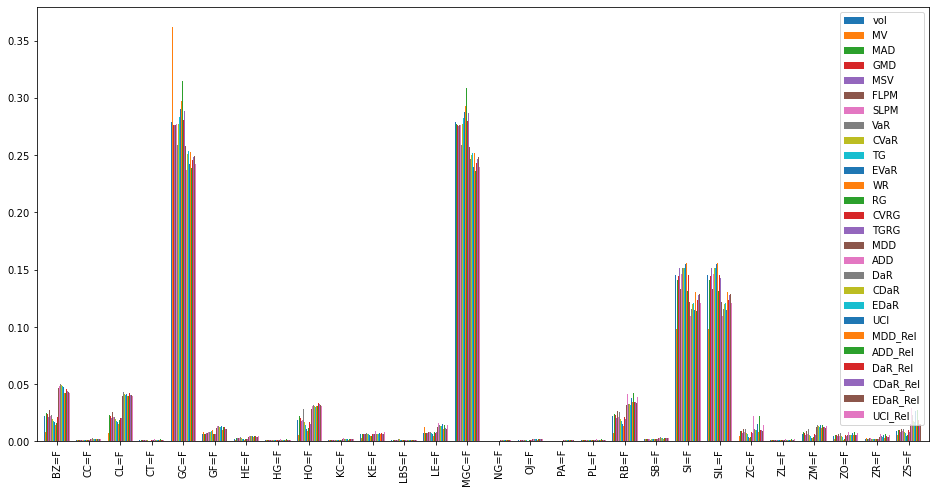

In [43]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(16)
fig.set_figheight(8)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot(kind='bar', width=0.8, ax=ax)